# Before / After Classification
My third classifier will investigate the differences between climate tweets made before COVID and after COVID. To do so, I will train a Naive Bayes classifier on my climate tweets and look at the most informative features.

In [1]:
import nltk
import random
from nltk.classify import apply_features
import re
import string
import emoji
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datascience import *
import cld3
%matplotlib inline

## Step 1: Load tweets, preprocess, and set up training and test sets
We will bring together climate tweets from all locations into one list. The list items are each of the format 
    
    (tweet_text, before_or_after)

In [2]:
twitter_username_re = re.compile(r"(^|[^\w@/\!?=&])@(\w{1,15})\b")
url_re = re.compile(r"\bhttps://t.co/\w+")
num_re = re.compile(r"\w*\d\w*")
hashtag_re = re.compile(r"\B(\#[a-zA-Z]+\b)(?!;)")

def is_english(tweet):
    # users, hashtags, numbers, urls mess with the detector, so remove them
    tweet = twitter_username_re.sub("", tweet)
    tweet = url_re.sub("", tweet)
    tweet = hashtag_re.sub(" ", tweet)
    tweet = tweet.replace("#", "").replace("…", "")
    tweet = tweet.replace("&amp;", "").replace("@", "")
    tweet = tweet.replace("<NEWLINE> ", "")
    
    try:
        lang = cld3.get_language(tweet)
        # if we're not sure, just say it's english
        if not lang.is_reliable:
            return True
        return lang.language == 'en'
    
    
    # again, if we're not sure, just say it's english
    except:
        return True

In [3]:
before_tweets = []
after_tweets  = []

before = open("../data-collection/climate-tweets/before-covid-climate-tweets-all.txt", "r")
for line in before:
    # ignore the type of climate change tweet
    reduced_line = '\t'.join(line.split('\t')[:-1])
    tweet_text = reduced_line.split('\t', 2)[2]
    # ignore retweets and non-english tweets
    if tweet_text[:2] == "RT" or not is_english(tweet_text):
        continue
    before_tweets.append((tweet_text.replace("<NEWLINE>", ""), 'before'))
before.close()

after = open("../data-collection/climate-tweets/after-covid-climate-tweets-all.txt", "r")
for line in after:
    # ignore the type of climate change tweet
    reduced_line = '\t'.join(line.split('\t')[:-1])
    tweet_text = reduced_line.split('\t', 2)[2]
    # ignore retweets and non-english tweets
    if tweet_text[:2] == "RT" or not is_english(tweet_text):
        continue
    after_tweets.append((tweet_text.replace("<NEWLINE>", ""), 'after'))
after.close()
        
print(len(before_tweets) + len(after_tweets), "total tweets (" + str(len(before_tweets)), " before,", len(after_tweets), "after)")

12797 total tweets (8160  before, 4637 after)


When we preprocess tweets, we want to 
- Make them lowercase
- Neutralize URLs, numbers, and usernames
- Remove emojis and punctuation
- Reduce repeated letters down to two (for example, 'ughhhhhh' becomes 'ughh')

As in previous classifiers, ```give_emoji_free_text``` is taken from the Towards Data Science [article](https://towardsdatascience.com/classifying-climate-change-tweets-8245450a5e96).

In [4]:
def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [5]:
def reduce_repeated_letters(tweet):
    reduced_tweet = ''
    prev_chars = ['', '']
    indices_to_remove = []
    
    for i in np.arange(len(tweet)):
        char = tweet[i]
        # if this char is a letter and is the same as the past two chars,
        # remove it from the end string
        if prev_chars[0] == prev_chars[1] and char == prev_chars[0]:
            if char in string.ascii_lowercase:
                indices_to_remove.append(i)
        prev_chars[1] = prev_chars[0]
        prev_chars[0] = char
        
    for i in np.arange(len(tweet)):
        if i not in indices_to_remove:
            reduced_tweet += tweet[i]
            
    return reduced_tweet

In [6]:
twitter_username_re = re.compile(r"(^|[^\w@/\!?=&])@(\w{1,15})\b")
url_re  = re.compile(r"\bhttps://t.co/\w+")
num_re  = re.compile(r"\w*\d\w*")
punc_re = re.compile(r"[{}]".format(string.punctuation))

def clean_tweet(tweet): 
    # make lowercase
    tweet = tweet.lower()
    
    # neutralize usernames, urls, and numbers
    tweet = twitter_username_re.sub(" USERNAME", tweet)
    tweet = url_re.sub(" URL", tweet)
    tweet = num_re.sub(" NUMBER", tweet)
    
    # remove emojis and leftover punctuation
    tweet = give_emoji_free_text(tweet)
    tweet = punc_re.sub("", tweet)
    
    # reduce repeated letters
    tweet = reduce_repeated_letters(tweet)
    
    # make truncation character its own word
    tweet = tweet.replace("…", " …")
        
    return tweet

In [7]:
before_tweets = [(clean_tweet(x), l) for (x, l) in before_tweets]
after_tweets  = [(clean_tweet(x), l) for (x, l) in after_tweets]

Now we partition into training and test sets. We will do an 80/10/10 split (train, test, devtest).

In [8]:
# partition into training and test sets
random.Random(19).shuffle(before_tweets)
random.Random(24).shuffle(after_tweets)

# we want to do 80% train, 20% test
before_num_test = int(len(before_tweets) * 0.2)
after_num_test  = int(len(after_tweets)  * 0.2)

# keep the before/after balance the same in all sets 
test_tweets  = before_tweets[:before_num_test] + after_tweets[:after_num_test]
train_tweets = before_tweets[before_num_test:] + after_tweets[after_num_test:]

random.Random(17).shuffle(test_tweets)
random.Random(17).shuffle(train_tweets)

print(len(test_tweets), "test tweets,", len(train_tweets), "training tweets")

2559 test tweets, 10238 training tweets


In [9]:
test_tweets[:5]

[('knot poufs with wood rings  perfection prodeez by knots studio inspiring dreamdesigndisrupt inspo … URL',
  'before'),
 ('nasa provided the analysis dropping the mic  noplanb actonclimate parisagreement URL',
  'before'),
 ('huge congratulations to my boss USERNAME returned by the people of preseli and to my friend USERNAME who ma … URL',
  'before'),
 ('USERNAME i see supermarkets are busy environments hope this iswill be better soonwith time i now do my … URL',
  'before'),
 ('USERNAME sounds like someone who cares about the environment', 'before')]

## Step 2: Define feature-generator

Our feature generator will include as features
- each unique word in the tweet
- how many numbers there are
- how many usernames are mentioned
- how many urls there are
- whether the tweet was truncated

I take care not to include any COVID-related terms in the feature set, since those would be dead easy pointers to being tweeted after COVID.

EDIT: I must have also gathered tweets from a) someone who loves nailpolish and uses lots of hashtags, and b) someone who tweets the weather every day. Presumably each tweet from these people was showing up with the same hashtags/terms, so those became some of the most informative features. I decided to ignore those too because... they were annoying. 

In [11]:
ignore_terms = ["coronavirus", "corona", "virus", "covid", "rona", "miss rona", 
               "pandemic", "lockdown", "quarantine", "wfh", "fauci", "wuhan",
               "nails", "nailpolish", "nailpolishaddict", "apr", "hi", "lo"] 

def gen_feats(tweet):
    tweet_toks = nltk.word_tokenize(tweet)    
    featdict = {}
    
    featdict['num-tokens'] = len(tweet_toks)
    
    # get unigrams, hashtag, truncated
    for w in tweet_toks:
        if w not in ignore_terms and w != '…':
            featdict['contains-' + w.lower()] = 1
        elif w == '…':
            featdict['truncated'] = 1
            
    # add bigrams
    for i in np.arange(len(tweet_toks) - 1):
        w1 = tweet_toks[i]
        w2 = tweet_toks[i + 1]
        
        if w1 in ignore_terms or w2 in ignore_terms:
            continue
        
        bigram = w1 + " " + w2
        if '…' in bigram:
            continue
        
        featdict['contains-(' + bigram.lower() + ')'] = 1
        
    # add trigrams
    for i in np.arange(len(tweet_toks) - 2):
        w1 = tweet_toks[i]
        w2 = tweet_toks[i + 1]
        w3 = tweet_toks[i + 2]
        
        if w1 in ignore_terms or w2 in ignore_terms or w3 in ignore_terms:
            continue
        
        trigram = w1 + " " + w2 + " " + w3
        if '…' in trigram:
            continue
            
        featdict['contains-(' + trigram.lower() + ')'] = 1
        
    return featdict

In [12]:
test_feats  = apply_features(gen_feats, test_tweets)
train_feats = apply_features(gen_feats, train_tweets)

## Step 3: Train classifier
I'll train a Naive Bayes classifier on the feature sets of the training tweets, then analyze its initial performance.

In [14]:
nb = nltk.NaiveBayesClassifier.train(train_feats)
accuracy = nltk.classify.accuracy(nb, test_feats)
print("Accuracy score:", accuracy)

Accuracy score: 0.7299726455646737


In [15]:
b_guess_b, a_guess_a, b_guess_a, a_guess_b = [], [], [], []
y_true = []
y_pred = []

for (tweet, date) in test_tweets:
    guess = nb.classify(gen_feats(tweet))
    y_true.append(date)
    y_pred.append(guess)
    if date == 'before':
        if guess == 'before':
            b_guess_b.append((tweet, guess, date))
        else:
            b_guess_a.append((tweet, guess, date))
    elif date == 'after':
        if guess == 'after':
            a_guess_a.append((tweet, guess, date))
        else:
            a_guess_b.append((tweet, guess, date))

print(len(b_guess_b), "correctly guessed as BEFORE")
print(len(a_guess_a), "correctly guessed as AFTER")
print(len(b_guess_a), "guessed as AFTER when they were actually BEFORE")
print(len(a_guess_b), "guessed as BEFORE when they were actually AFTER")

1190 correctly guessed as BEFORE
678 correctly guessed as AFTER
442 guessed as AFTER when they were actually BEFORE
249 guessed as BEFORE when they were actually AFTER


As in the previous classifiers, this confusion matrix function comes from the Towards Data Science [article](https://towardsdatascience.com/classifying-climate-change-tweets-8245450a5e96) by Andrew Graves.

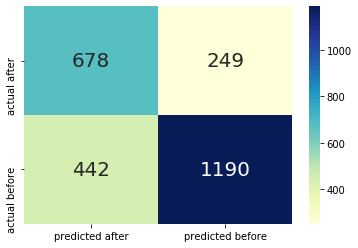

In [16]:
# Confusion Matrix Function
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted after', 'predicted before'], 
                yticklabels=['actual after', 'actual before'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

conf_matrix(y_true, y_pred)

In [17]:
for x in (b_guess_b, a_guess_a, b_guess_a, a_guess_b):
    tweet, guess, date = random.choice(x)
    print("Real =", date.upper() + ", Guess =", guess.upper())
    print(tweet + '\n')

Real = BEFORE, Guess = BEFORE
baobab terrific skincare under the sun immaculate white zero sugar zero soy zero palm oil zero grains vegan … URL

Real = AFTER, Guess = AFTER
being in a real work environment when studying an apprenticeship gives you the chance to make a good name for your … URL

Real = BEFORE, Guess = AFTER
USERNAME wow you must not have heard that we’re actually trying to speed up global warming to melt that suck … URL

Real = AFTER, Guess = BEFORE
comfort food and a salad cozhealth vegan vegancooking macncheesespecial URL



In [18]:
nb.show_most_informative_features(50)

Most Informative Features
contains-(number number url) = 1               after : before =     95.6 : 1.0
      contains-universal = 1               after : before =     45.2 : 1.0
           contains-intl = 1               after : before =     40.5 : 1.0
contains-(the current climate) = 1               after : before =     40.5 : 1.0
  contains-climatestrike = 1              before : after  =     38.8 : 1.0
       contains-heatwave = 1              before : after  =     38.1 : 1.0
contains-(current climate) = 1               after : before =     33.4 : 1.0
     contains-(plan for) = 1               after : before =     33.4 : 1.0
        contains-airport = 1               after : before =     32.9 : 1.0
          contains-biden = 1               after : before =     31.1 : 1.0
contains-(number climate) = 1               after : before =     29.8 : 1.0
  contains-(url science) = 1               after : before =     27.8 : 1.0
           contains-snow = 1               after : before =  

In [19]:
most_inf_feats = [f.replace("contains-", "") for (f, x) in nb.most_informative_features(50) if f.strip != ""]
weights = [(nb.prob_classify({'contains-' + feat: 1}).prob('after') - 0.5) for feat in most_inf_feats]

In [20]:
feats_table = Table().with_columns("feature", most_inf_feats,
                                   "weight (towards after)", weights)
feats_table = feats_table.sort("weight (towards after)", descending=True)
feats_table.barh("feature", width = 15, height = 22)

/Users/Soph/.pyenv/versions/3.8.1/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Soph/.pyenv/versions/3.8.1/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Soph/.pyenv/versions/3.8.1/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8297 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Soph/.pyenv/versions/3.8.1/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8294 missing from current font.
  font.set_text(s, 0, flags=flags)


In [21]:
nb.prob_classify({}).prob('after')

0.3623889051665201